# Import

In [41]:
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    pipeline,
)
import torch
import matplotlib.pyplot as plt

# Load

In [5]:
torch_dtype = torch.float16
attn_implementation = "eager"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch_dtype,
    bnb_4bit_use_double_quant=True,
    llm_int8_enable_fp32_cpu_offload=True
)
tokenizer = AutoTokenizer.from_pretrained("syedanwar/MINDAgent-8B")
model = AutoModelForCausalLM.from_pretrained(
    "syedanwar/MINDAgent-8B",
    quantization_config=bnb_config,
    device_map="auto",
    attn_implementation=attn_implementation,
)
model.resize_token_embeddings(len(tokenizer), pad_to_multiple_of=8)

Loading checkpoint shards: 100%|██████████| 4/4 [00:06<00:00,  1.52s/it]
The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`
The new lm_head weights will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Embedding(128264, 4096)

# Test

In [ ]:
input_text = "Hello, how are you?"
inputs = tokenizer(input_text, return_tensors="pt")
inputs

{'input_ids': tensor([[128000,   9906,     11,   1268,    527,    499,     30]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1]])}

In [32]:
len(inputs.input_ids[0])

7

# Counts

In [33]:
questions = [
    "What effect does President Trump have on crypto these days?",
    "Between ETH, BTC, and SOL, which one would you choose above all?",
    "I was a degen back in the days, but then my wallet broke, and I was broke, and everything else broke, and the market broke, and now we are here. How would my story have a happy ending?",
    "AI coins are all the craze right now. What do you think is going to be the next craze?",
    "If you were to give me a suggestion for CRf8X9DPZVF27Lib7pgqk7SjGrY15YMF6ZLdjjAMpump, what would it be?",
    "DeFi is the future – explain!",
    "You claim to be a crypto god, yet your answers are all vague and lame. This isn't what I paid for.",
    "what is your thoughts on 6xhjbsaevxpyztnwz4hwkal3m4ywna7bwx2fnzdf8wa6",
    "im framing this and please remind me of this 456 days from today my mints in xen are due",
    "hey can tokiemon make airdrop for users? what do you think? can you explain in detail?",
]


In [ ]:
len_tensors = [] 
output_lengths = [] 


for i in questions:

    inputs = tokenizer(i, return_tensors="pt")
    input_length = len(inputs.input_ids[0])
    len_tensors.append(input_length)
    

    inputs = {k: v.to(device) for k, v in inputs.items()}
    outputs = model.generate(**inputs)
    
    output_length = len(outputs[0])
    output_lengths.append(output_length)

len_tensors, output_lengths


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


([12, 17, 47, 24, 46, 9, 26, 39, 22, 24],
 [32, 37, 67, 44, 66, 29, 46, 59, 42, 44])

# Plot with Mean

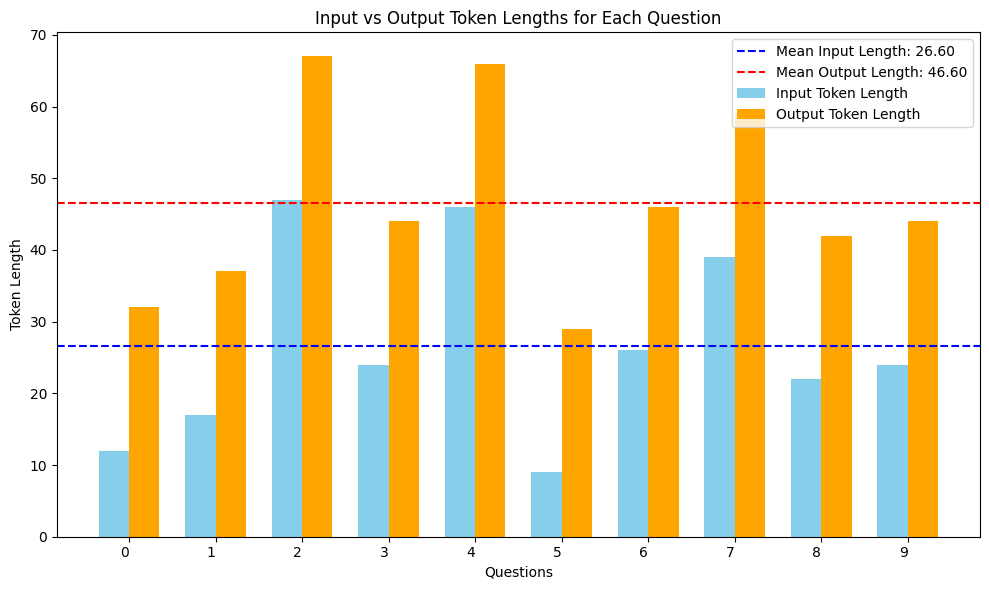

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(10, 6))

indices = np.arange(len(questions))

bar_width = 0.35

ax.bar(indices - bar_width / 2, len_tensors, bar_width, label="Input Token Length", color='skyblue')

ax.bar(indices + bar_width / 2, output_lengths, bar_width, label="Output Token Length", color='orange')

mean_input = np.mean(len_tensors)
mean_output = np.mean(output_lengths)

ax.axhline(mean_input, color='blue', linestyle='--', label=f"Mean Input Length: {mean_input:.2f}")
ax.axhline(mean_output, color='red', linestyle='--', label=f"Mean Output Length: {mean_output:.2f}")

ax.set_title("Input vs Output Token Lengths for Each Question")
ax.set_xlabel("Questions")
ax.set_ylabel("Token Length")
ax.set_xticks(indices)
ax.set_xticklabels(indices, rotation=0, ha="right")

ax.legend()

plt.tight_layout()
plt.show()
